In [1]:
import os
import re
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile
import shutil
from matplotlib.colors import TwoSlopeNorm

plt.rcParams['figure.figsize'] = (3.5, 3)
%matplotlib inline

In [2]:
#os.chdir('/Users/wsun/research/CAT/Li_2025')
#print(os.getcwd())  # To confirm

data_dir = "GSE288199_raw"
sample_dirs = [d for d in os.listdir(data_dir)
               if os.path.isdir(os.path.join(data_dir, d))]

In [3]:
def read_10x_custom(sample_dir, var_names='gene_symbols'):
    """
    Use sc.read_10x_mtx() on a folder that has nonstandard 10x filenames by
    copying them into a temporary folder (with the standard 10x names).
    """
    
    # Find the files in sample_dir that end with _matrix.mtx.gz, etc.
    filenames = os.listdir(sample_dir)
    mtx_file  = [f for f in filenames if f.endswith("_matrix.mtx.gz")]
    bc_file   = [f for f in filenames if f.endswith("_barcodes.tsv.gz")]
    feat_file = [f for f in filenames if f.endswith("_features.tsv.gz")]

    if not (mtx_file and bc_file and feat_file):
        raise FileNotFoundError(
            f"Could not find matrix/barcodes/features in {sample_dir} with the suffixes:"
            " _matrix.mtx.gz, _barcodes.tsv.gz, _features.tsv.gz"
        )

    mtx_path  = os.path.join(sample_dir, mtx_file[0])
    bc_path   = os.path.join(sample_dir, bc_file[0])
    feat_path = os.path.join(sample_dir, feat_file[0])

    # Create a temp folder
    tmpdir = tempfile.mkdtemp(prefix="10x_temp_")
    try:
        # Copy the three files with standard 10x names
        shutil.copy(mtx_path,  os.path.join(tmpdir, "matrix.mtx.gz"))
        shutil.copy(bc_path,   os.path.join(tmpdir, "barcodes.tsv.gz"))
        shutil.copy(feat_path, os.path.join(tmpdir, "features.tsv.gz"))

        # Now read_10x_mtx will see them as the standard 10x file names
        adata = sc.read_10x_mtx(
            tmpdir, 
            var_names=var_names, 
            make_unique=True
        )
    finally:
        # Clean up the temp directory
        shutil.rmtree(tmpdir)

    return adata

In [4]:
# ----------------------- read in data -------------------------
adatas = []
for s1 in sample_dirs:
    adata = read_10x_custom(f'GSE288199_raw/{s1}')

    # make cell barcodes globally unique (sample suffix)
    new_index = [bc.rsplit('-', 1)[0] + f"-{s1}" for bc in adata.obs.index]
    adata.obs.index = new_index
    adata.obs["sample"] = s1
    adatas.append(adata)

# -------------------------- concatenate samples ---------------------------
adata_all = ad.concat(adatas, join="outer", label="sample", keys=sample_dirs)

In [5]:
print(adata_all)

print(adata_all.X[20:25, 20:25].todense())
print(adata_all.obs.head())
print(adata_all.var.head())

AnnData object with n_obs × n_vars = 425770 × 33545
    obs: 'sample'
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]]
                               sample
AAACCTGAGATCCGAG-HN12_post  HN12_post
AAACCTGAGGCTAGCA-HN12_post  HN12_post
AAACCTGCAGCATGAG-HN12_post  HN12_post
AAACCTGGTTCCACAA-HN12_post  HN12_post
AAACCTGTCAAAGTAG-HN12_post  HN12_post
Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3]


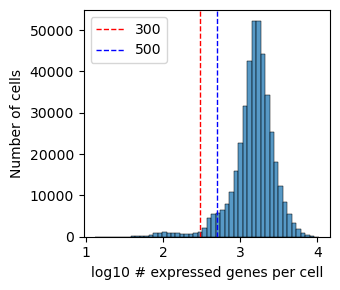

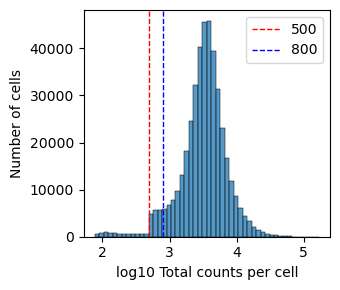

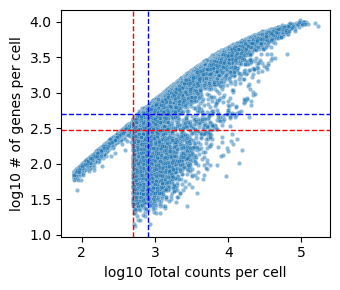

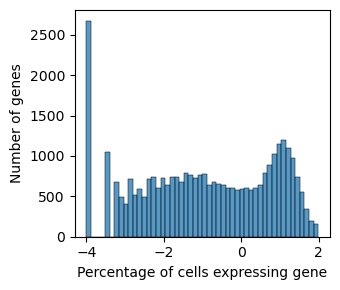

Summary of genes/counts per cell
count    425770.000000
mean       1734.670350
std         953.882539
min          13.000000
25%        1145.000000
50%        1581.000000
75%        2127.000000
max       10445.000000
Name: n_genes_expressed, dtype: float64
count    425770.000000
mean       4223.156250
std        3852.342285
min          77.000000
25%        2217.000000
50%        3408.000000
75%        5002.000000
max      167280.000000
Name: total_counts, dtype: float64
Summary of percent of cells expressing each gene
count    33545.000000
mean         5.171174
std         11.539555
min          0.000000
25%          0.004697
50%          0.120018
75%          4.622918
max         98.836461
Name: pct_cells_expressed, dtype: float64


In [6]:
adata_all.obs['n_genes_expressed'] = (adata_all.X > 0).sum(axis=1).A1  # .A1 flattens sparse matrix result
sns.histplot(np.log10(adata_all.obs['n_genes_expressed']), bins=50, kde=False)
plt.xlabel('log10 # expressed genes per cell')
plt.ylabel('Number of cells')
plt.axvline(np.log10(300), color='red', linestyle='--', linewidth=1, label='300')
plt.axvline(np.log10(500), color='blue', linestyle='--', linewidth=1, label='500')
plt.legend()
# plt.legend(handles=[line1, line2], loc='upper left')
plt.tight_layout()
plt.show()


adata_all.obs['total_counts'] = adata_all.X.sum(axis=1).A1  # .A1 flattens the sparse matrix row sums
sns.histplot(np.log10(adata_all.obs['total_counts']), bins=50, kde=False)
plt.xlabel('log10 Total counts per cell')
plt.ylabel('Number of cells')
plt.axvline(np.log10(500), color='red', linestyle='--', linewidth=1, label='500')
plt.axvline(np.log10(800), color='blue', linestyle='--', linewidth=1, label='800')
plt.legend()
plt.tight_layout()
plt.show()

# Scatterplot of log10(total_counts) vs log10(n_genes_expressed)
sns.scatterplot(
    x=np.log10(adata_all.obs['total_counts']),
    y=np.log10(adata_all.obs['n_genes_expressed']),
    alpha=0.5, s=10
)
plt.xlabel('log10 Total counts per cell')
plt.ylabel('log10 # of genes per cell')
plt.axhline(np.log10(300), color='red', linestyle='--', linewidth=1)
plt.axhline(np.log10(500), color='blue', linestyle='--', linewidth=1)
plt.axvline(np.log10(500), color='red', linestyle='--', linewidth=1)
plt.axvline(np.log10(800), color='blue', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

n_cells = adata_all.n_obs
adata_all.var['pct_cells_expressed'] = np.asarray((adata_all.X > 0).sum(axis=0)).ravel() / n_cells * 100
sns.histplot(np.log10(adata_all.var['pct_cells_expressed']+1e-4), bins=50, kde=False)
plt.xlabel('Percentage of cells expressing gene')
plt.ylabel('Number of genes')
plt.tight_layout()
plt.show()

print("Summary of genes/counts per cell")
print(adata_all.obs['n_genes_expressed'].describe())
print(adata_all.obs['total_counts'].describe())

print("Summary of percent of cells expressing each gene")
print(adata_all.var['pct_cells_expressed'].describe())


In [7]:
print(adata_all.shape)
print(type(adata_all))

(425770, 33545)
<class 'anndata._core.anndata.AnnData'>


In [8]:
# ----------------------- filter cells and genes -------------------------
# Filter cells based on number of genes expressed
sc.pp.filter_cells(adata_all, min_genes=300)
min_cells = int(adata_all.n_obs * 0.01)
print(f"Filtering genes expressed in at least {min_cells} cells")
sc.pp.filter_genes(adata_all, min_cells=min_cells)

print(adata_all.shape)
# basic normalisation / log1p 
sc.pp.normalize_total(adata_all, target_sum=5000)
sc.pp.log1p(adata_all)


Filtering genes expressed in at least 4156 cells
(415640, 11952)


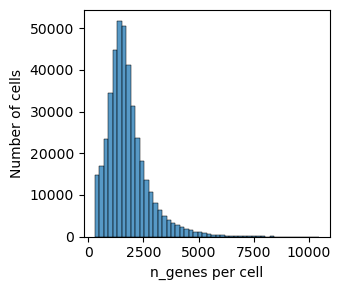

In [9]:
sns.histplot(adata_all.obs['n_genes_expressed'], bins=50, kde=False)
plt.xlabel('n_genes per cell')
plt.ylabel('Number of cells')
plt.tight_layout()
plt.show()

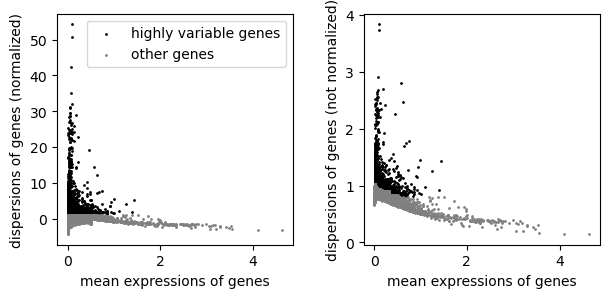

In [10]:
hvg_n         = 2000                           # #HVGs to keep
leiden_res    = 0.6                            # tweak for cluster granularity

# -------------------- feature selection & scaling -------------------------
sc.pp.highly_variable_genes(adata_all, n_top_genes=hvg_n, flavor="cell_ranger")
sc.pl.highly_variable_genes(adata_all)


In [11]:
cd3_genes = [g for g in adata_all.var_names if g.startswith("CD3")]
print(cd3_genes)

additional_genes = ["CD3D", "CD3E"]
genes_to_include = [gene for gene in additional_genes if gene in adata_all.var_names]
print(genes_to_include)

['CD38', 'CD36', 'CD3E', 'CD3D', 'CD3G', 'CD300A', 'CD320', 'CD3EAP', 'CD37']
['CD3D', 'CD3E']


In [12]:
hvg_genes = adata_all.var_names[adata_all.var['highly_variable']].tolist()
if 'CD3D' not in hvg_genes:
    hvg_genes.append('CD3D')
if 'CD3E' not in hvg_genes:
    hvg_genes.append('CD3E')

adata_all = adata_all[:, hvg_genes]
sc.pp.scale(adata_all, max_value=10)
print(adata_all.shape)
# ----------------------- dimensionality + clustering ----------------------
sc.tl.pca(adata_all, svd_solver="arpack")


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(415640, 2002)


[0.02760236 0.02599841 0.01549376 0.01397133 0.00649142 0.00610427
 0.00545381 0.00478615 0.00349531 0.00324753 0.00296721 0.00268559
 0.00250306 0.00234985 0.00215224 0.00211178 0.0020443  0.00186154
 0.00174841 0.00167872 0.00157332 0.00154188 0.00150107 0.00148144
 0.00138557 0.00135484 0.00132508 0.00127713 0.00122082 0.0012116
 0.00116492 0.00111799 0.00111512 0.00108609 0.00107544 0.00105335
 0.0010309  0.00102252 0.00100553 0.00099044 0.00097814 0.00096996
 0.00094408 0.00093303 0.0009205  0.0008988  0.00088955 0.00087684
 0.00086761 0.00085761]


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


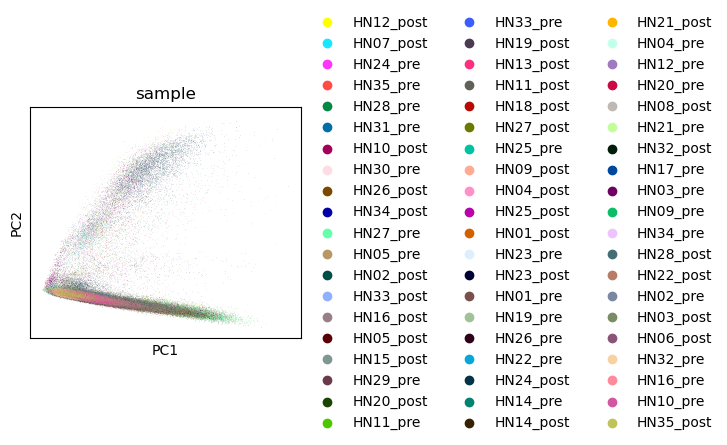

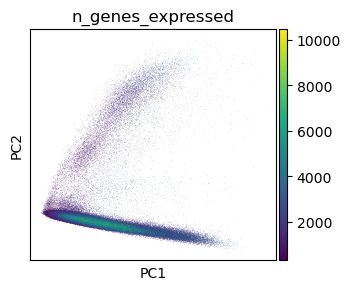

In [13]:
adata_all.uns['pca']['variance_ratio']
print(adata_all.uns['pca']['variance_ratio'])

sc.pl.pca(adata_all, color="sample", use_raw=False)
sc.pl.pca(adata_all, color="n_genes_expressed", use_raw=False)

In [14]:
pc1_values = adata_all.obsm['X_pca'][:, 0]
adata_all.obs['PC1'] = pc1_values
top_pc1_cells = adata_all.obs.sort_values('PC1', ascending=False).head(1000)
top_pc1_samples = top_pc1_cells['sample'].value_counts()
print(top_pc1_samples)


HN27_pre     558
HN26_pre      63
HN11_post     52
HN24_post     41
HN04_post     40
HN12_post     39
HN27_post     26
HN22_post     25
HN11_pre      23
HN03_pre      19
HN13_post     12
HN01_post     10
HN35_post      9
HN33_post      9
HN28_post      9
HN14_post      7
HN10_post      7
HN03_post      6
HN23_pre       6
HN05_pre       5
HN18_post      5
HN28_pre       5
HN04_pre       3
HN14_pre       3
HN10_pre       3
HN19_pre       3
HN32_pre       2
HN20_post      2
HN23_post      2
HN16_pre       1
HN02_pre       1
HN22_pre       1
HN25_post      1
HN09_post      1
HN05_post      1
HN07_post      0
HN17_pre       0
HN16_post      0
HN15_post      0
HN06_post      0
HN29_pre       0
HN33_pre       0
HN24_pre       0
HN19_post      0
HN34_pre       0
HN09_pre       0
HN35_pre       0
HN32_post      0
HN01_pre       0
HN21_pre       0
HN08_post      0
HN20_pre       0
HN12_pre       0
HN34_post      0
HN21_post      0
HN26_post      0
HN30_pre       0
HN25_pre       0
HN31_pre      

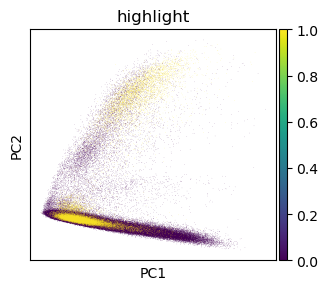

In [15]:
adata_all.obs['highlight'] = (adata_all.obs['sample'] == "HN24_post").astype(int)
sc.pl.pca(adata_all, color="highlight", use_raw=False)

In [16]:
sc.pp.neighbors(adata_all, n_pcs=50, metric="cosine")
sc.tl.leiden(adata_all, resolution=leiden_res, key_added="cluster")
sc.tl.umap(adata_all)

/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10

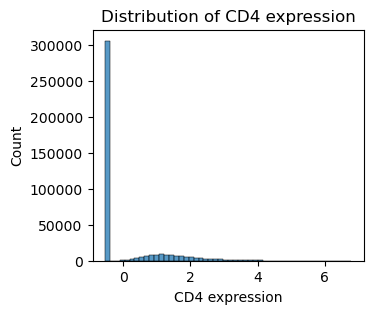

In [17]:
cd4_expr = adata_all[:, 'CD4'].X
if not isinstance(cd4_expr, np.ndarray):
    cd4_expr = cd4_expr.toarray().flatten()
else:
    cd4_expr = cd4_expr.flatten()
sns.histplot(cd4_expr, bins=50)
plt.xlabel('CD4 expression')
plt.title('Distribution of CD4 expression')
plt.show()

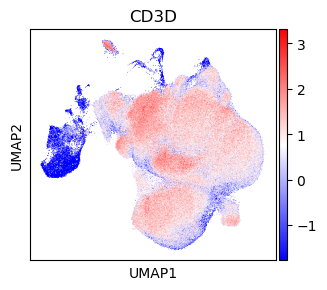

In [18]:
sc.pl.umap(
    adata_all,
    color='CD3D',
    color_map='bwr',
    size=1)


['CD3D', 'CD3E', 'CD4', 'FOXP3', 'CD8A', 'CD8B', 'GZMB', 'NKG7', 'IL7R', 'CCR7', 'SELL']


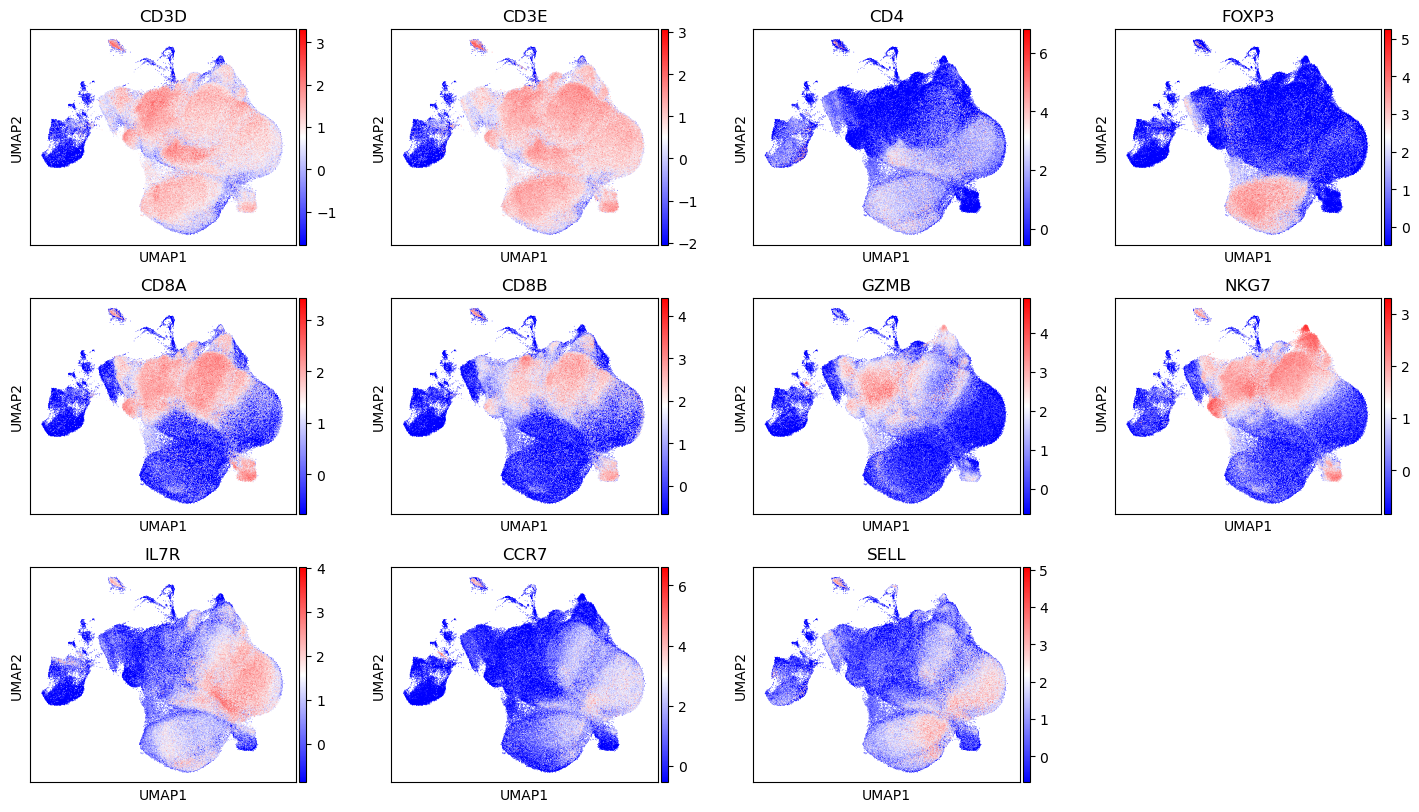

In [19]:
# Flatten the marker gene list
all_marker_genes = ['CD3D', 'CD3E', 'CD4', 'FOXP3', 'CD8A', 'CD8B', 'GZMB', 'NKG7',  'IL7R', 'CCR7', 'SELL']

genes_to_plot = [g for g in all_marker_genes if g in adata_all.var_names]
print(genes_to_plot)

# Plot with 4 columns per row
sc.pl.umap(
    adata_all,
    color=genes_to_plot,
    ncols=4,
    color_map='bwr',
    size=1
)


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No d

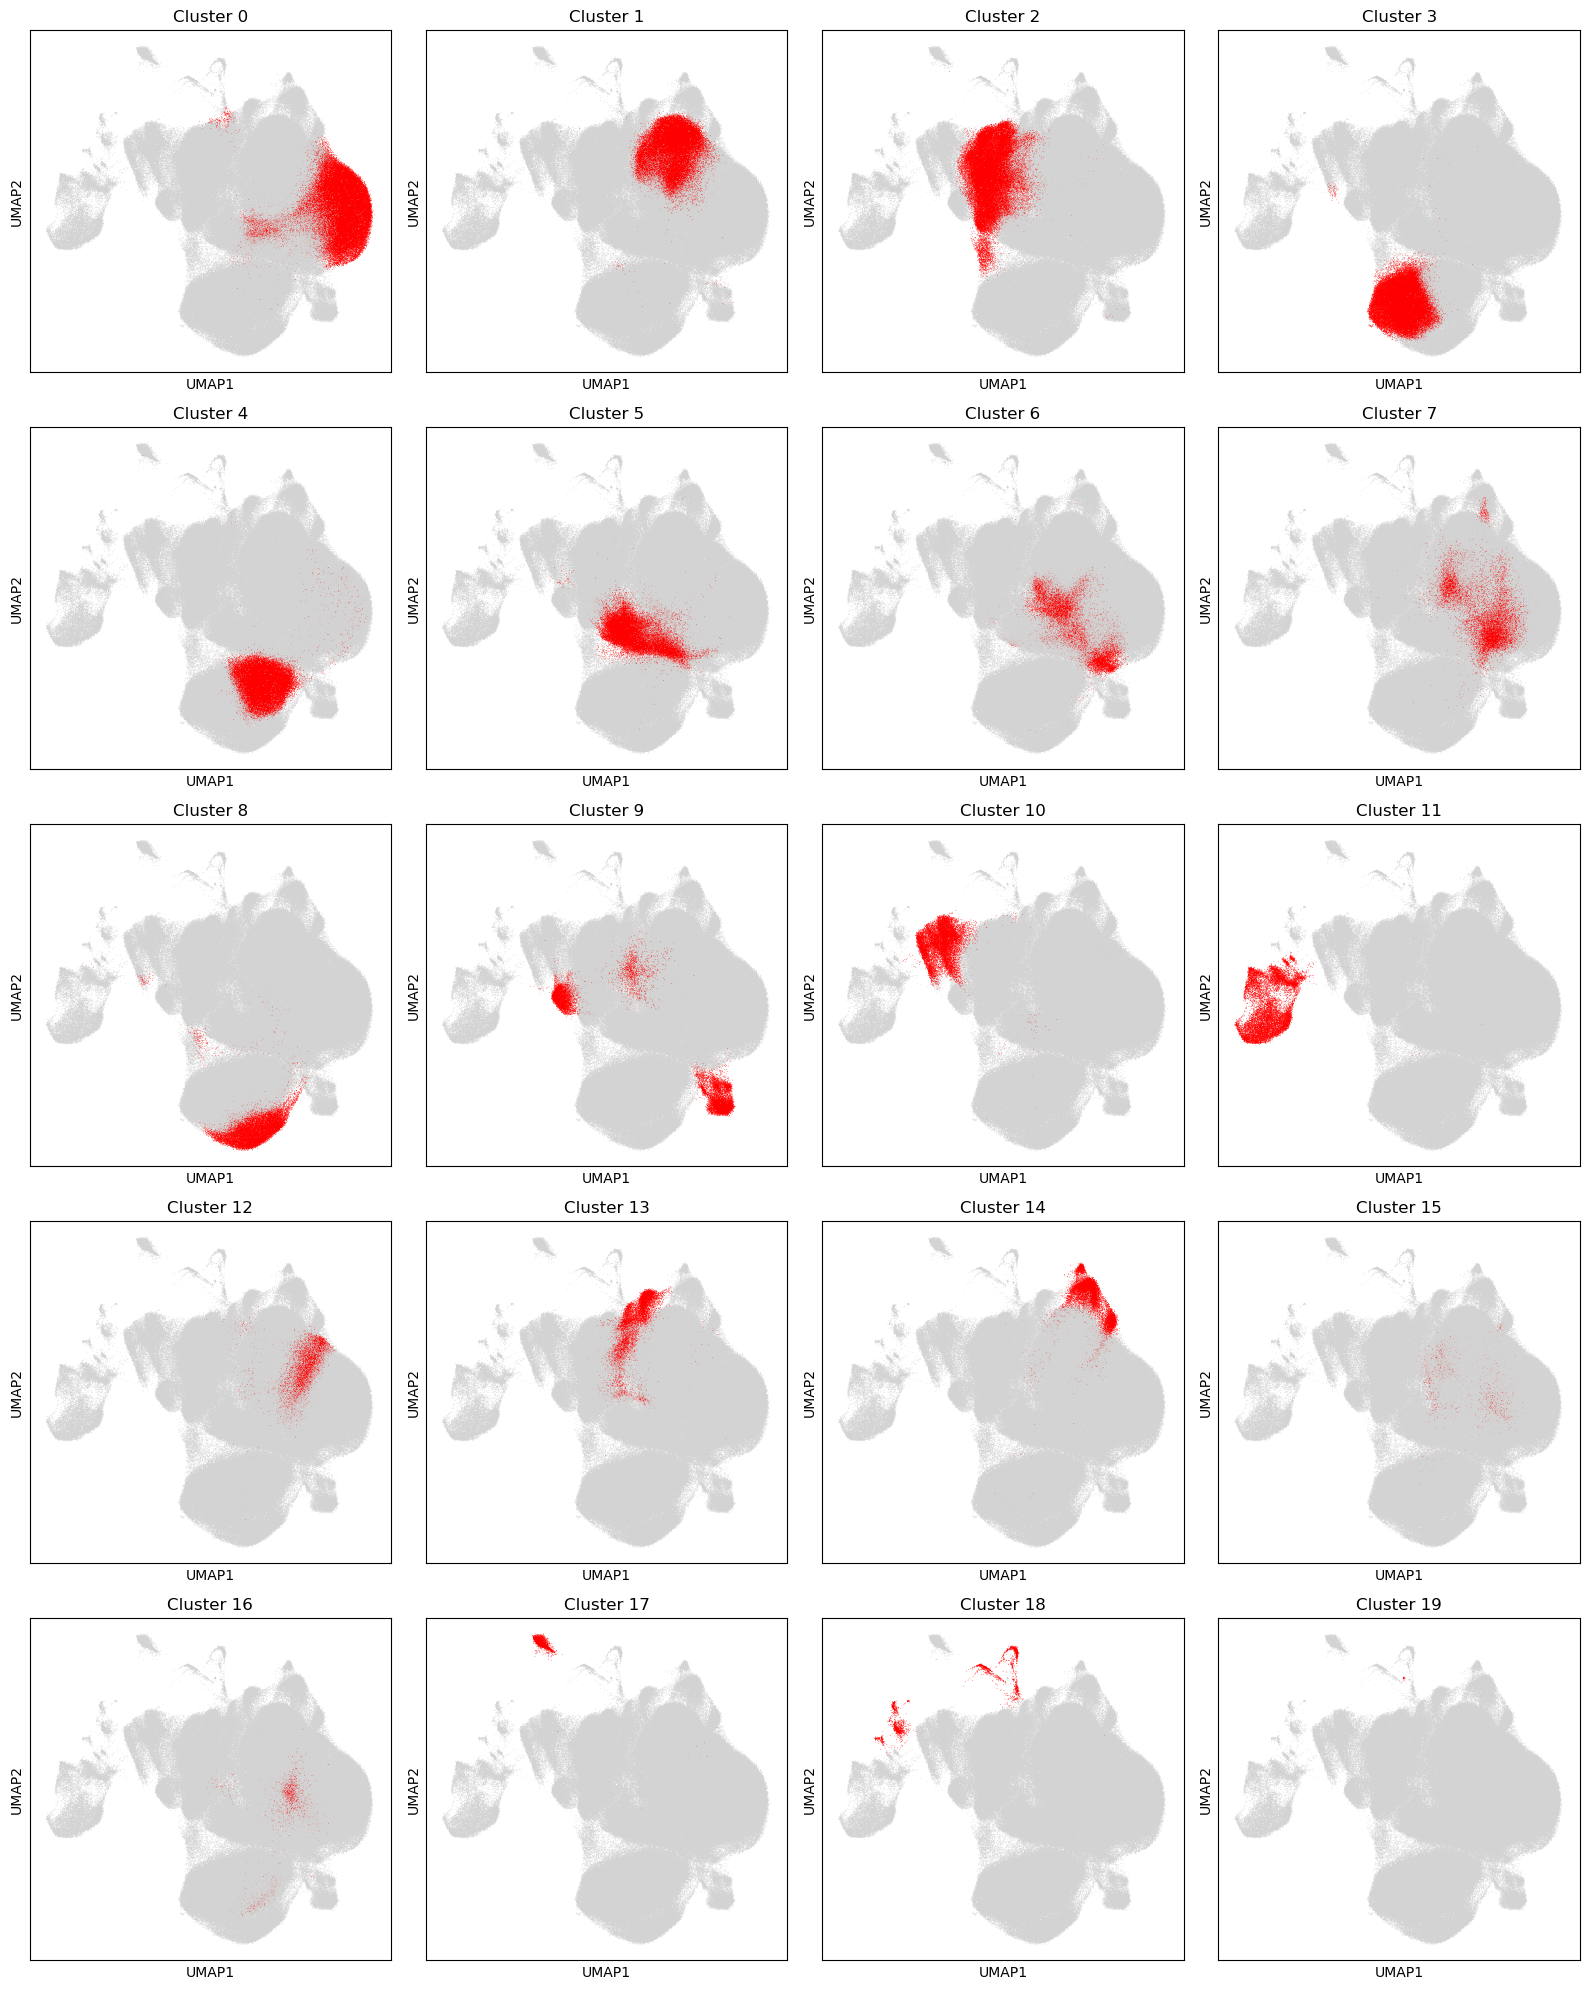

In [20]:
adata_all.obs['cluster'] = adata_all.obs['cluster'].astype(int)
clusters = sorted(adata_all.obs['cluster'].unique())

n = len(clusters)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

for ax, cluster in zip(axes.flat, clusters):
    adata_all.obs['highlight'] = (adata_all.obs['cluster'] == cluster).map({True: 'highlight', False: 'other'})
    
    sc.pl.umap(
        adata_all,
        color='highlight',
        palette={'highlight': 'red', 'other': 'lightgrey'},
        size=1,
        show=False,
        ax=ax,
        title=f"Cluster {cluster}",
        legend_loc=None
    )

# Hide any unused subplots
for ax in axes.flat[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.savefig("highlight_clusters_grid.png", dpi=300)
plt.show()

In [21]:
#   marker lists (feel free to expand)
markers = {
    "CD3": ["CD3D", "CD3E"],
    "CD4": ["CD4", "FOXP3"],
    "CD8": ["CD8A", "CD8B"],
}

# -------------------- CD4 / CD8 scores & predictions ----------------------
# per‑cell scores
sc.tl.score_genes(adata_all, gene_list=markers["CD3"], score_name="CD3_score", use_raw =False)
sc.tl.score_genes(adata_all, gene_list=markers["CD4"], score_name="CD4_score", use_raw =False)
sc.tl.score_genes(adata_all, gene_list=markers["CD8"], score_name="CD8_score", use_raw =False)


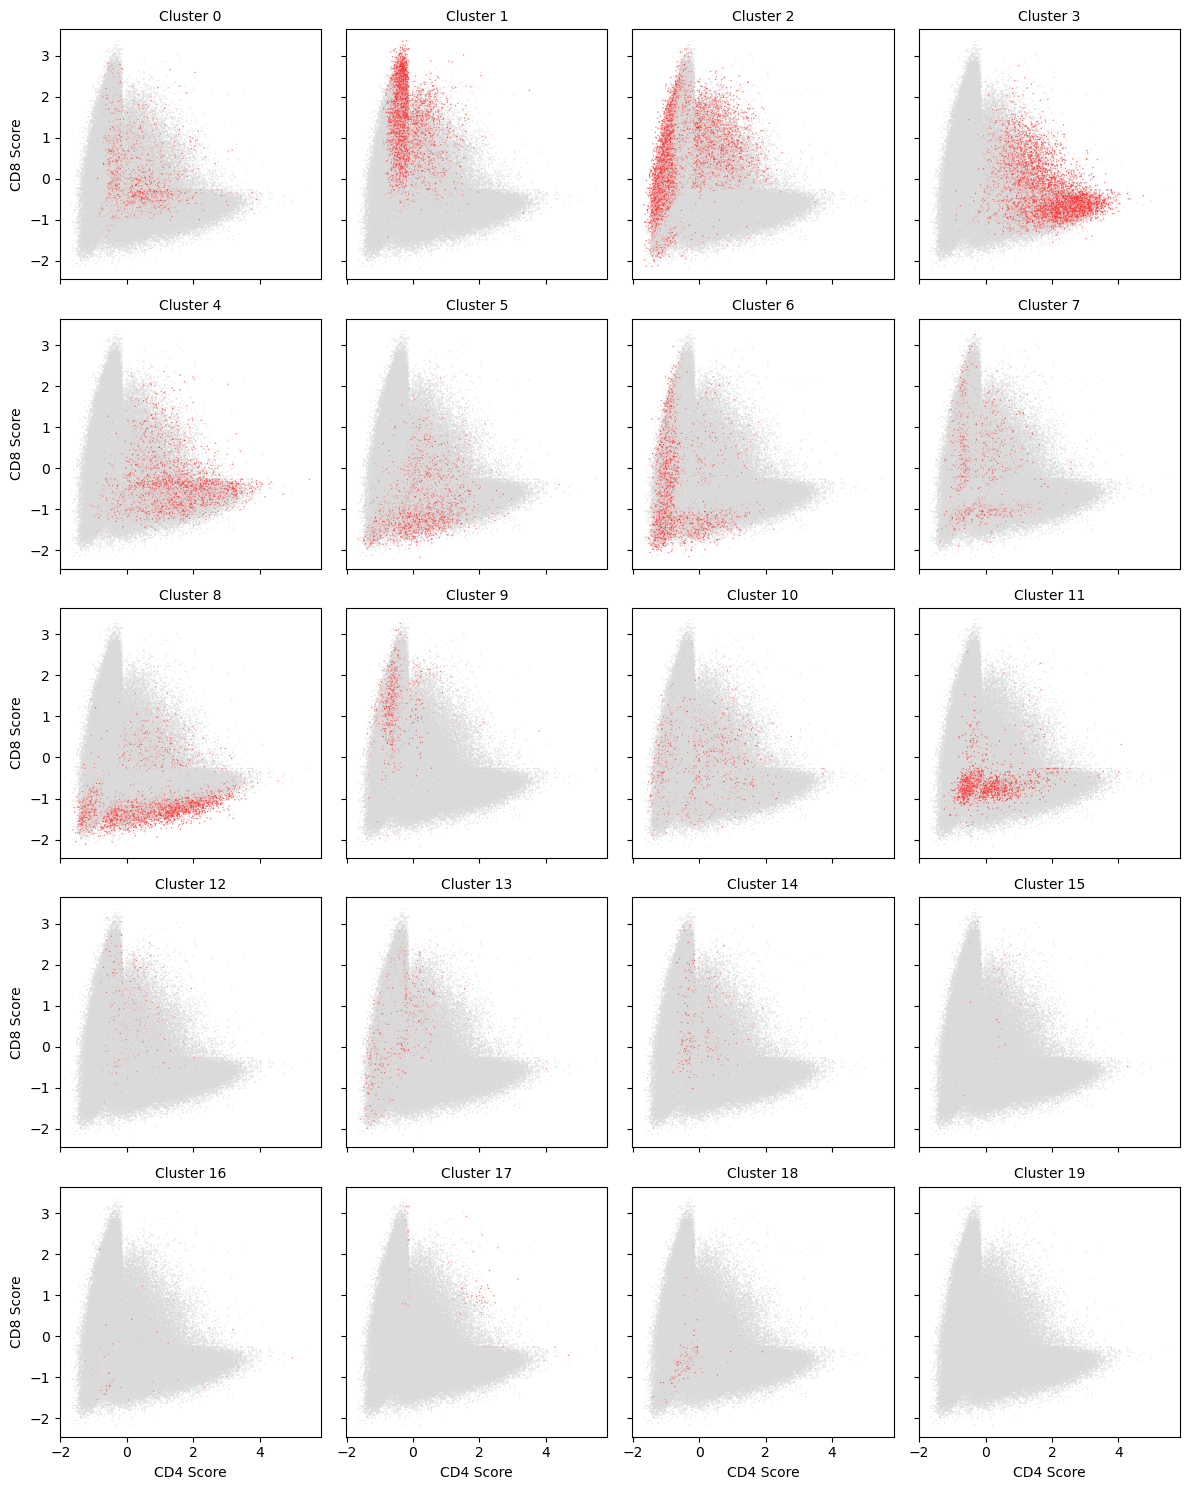

In [22]:
# Ensure cluster is integer and sorted
adata_all.obs['cluster'] = adata_all.obs['cluster'].astype(int)
clusters = sorted(adata_all.obs['cluster'].unique())

# Set grid dimensions
n_clusters = len(clusters)
ncols = 4  # adjust as needed
nrows = (n_clusters + ncols - 1) // ncols

# Create grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), sharex=True, sharey=True)

# Flatten axes for easy indexing
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Plot each cluster highlight
    sns.scatterplot(
        x=adata_all.obs['CD4_score'],
        y=adata_all.obs['CD8_score'],
        hue=(adata_all.obs['cluster'] == cluster),
        palette={True: 'red', False: 'lightgray'},
        alpha=0.6,
        s=1,
        legend=False,
        ax=ax
    )
    ax.set_title(f'Cluster {cluster}', fontsize=10)
    ax.set_xlabel('CD4 Score')
    ax.set_ylabel('CD8 Score')

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("cluster_cd4_cd8_grid.png", dpi=300)
plt.show()

In [23]:
# coarse per‑cluster means
clust_means = (
    adata_all.obs[["cluster", "CD3_score", "CD4_score", "CD8_score"]]
    .groupby("cluster")
    .mean()
)

proportion_cd4_gt_cd8 = (
    (adata_all.obs["CD4_score"] > adata_all.obs["CD8_score"])
    .groupby(adata_all.obs["cluster"])
    .mean()
)

clust_means["CD4_gt_CD8_fraction"] = proportion_cd4_gt_cd8

clust_means["predicted_type"] = np.where(
    (clust_means["CD3_score"] > -1.5) & 
    (clust_means["CD4_score"] > 0) & 
    (clust_means["CD8_score"] < 0) & 
    (clust_means["CD4_gt_CD8_fraction"] > 0.6), 
    "CD4", 
    np.where(
        (clust_means["CD3_score"] > -1.5) & 
        (clust_means["CD4_score"] < 0) & 
        (clust_means["CD8_score"] > 0) & 
        (clust_means["CD4_gt_CD8_fraction"] < 0.4), 
        "CD8", 
        "unknown"
    )
)

print(clust_means)

         CD3_score  CD4_score  CD8_score  CD4_gt_CD8_fraction predicted_type
cluster                                                                     
0         0.108409  -0.025377  -0.378154             0.835329        unknown
1         0.290406  -0.339259   0.938376             0.177224            CD8
2         0.321211  -0.516730   0.755644             0.098744            CD8
3         0.350765   1.301350  -0.592455             0.975673            CD4
4         0.050196   0.648974  -0.578525             0.957430            CD4
5         0.214304   0.185830  -0.690722             0.931381            CD4
6        -1.102290  -0.513685  -0.354877             0.535319        unknown
7         0.057946  -0.242093  -0.076089             0.602918        unknown
8        -1.097763   0.336329  -0.873327             0.896214            CD4
9         0.405987  -0.535982   1.112205             0.052162            CD8
10       -0.059042  -0.022726  -0.005696             0.515000        unknown

In [24]:
# map back to every cell
adata_all.obs["cell_type_by_cluster"] = (
    adata_all.obs["cluster"].map(clust_means["predicted_type"])
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


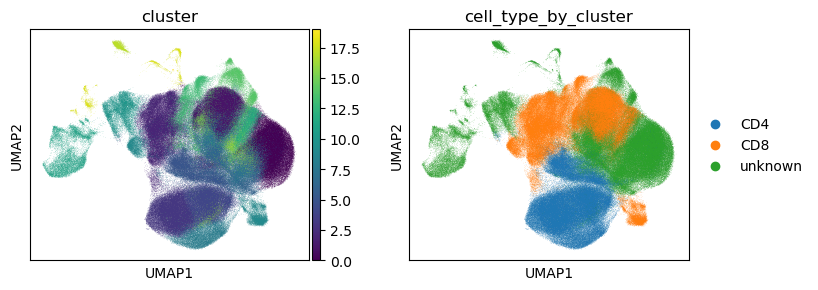

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


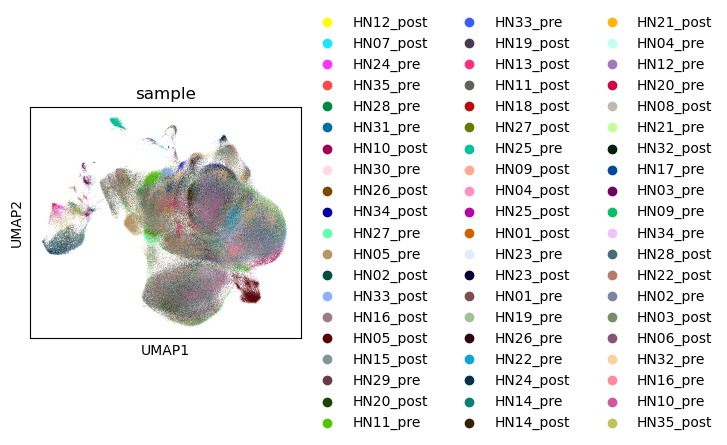

In [25]:
sc.pl.umap(adata_all, color=["cluster", "cell_type_by_cluster"])
sc.pl.umap(adata_all, color=["sample"])


In [26]:
pd.crosstab(adata_all.obs['cluster'], adata_all.obs['cell_type_by_cluster'])

cell_type_by_cluster    CD4    CD8  unknown
cluster                                    
0                         0      0    64656
1                         0  56708        0
2                         0  48661        0
3                     41723      0        0
4                     33686      0        0
5                     26494      0        0
6                         0      0    24406
7                         0      0    20492
8                     14713      0        0
9                         0  13439        0
10                        0      0    12767
11                        0      0    12740
12                        0  11825        0
13                        0  10408        0
14                        0      0    10401
15                        0      0     3932
16                        0      0     3143
17                        0      0     2802
18                        0      0     2620
19                        0      0       24

In [27]:
adata_all.obs

sample  n_genes_expressed  total_counts  \
AAACCTGAGATCCGAG-HN12_post  HN12_post               1291        2198.0   
AAACCTGAGGCTAGCA-HN12_post  HN12_post               2587        5507.0   
AAACCTGCAGCATGAG-HN12_post  HN12_post               1825        4072.0   
AAACCTGGTTCCACAA-HN12_post  HN12_post               2144        4738.0   
AAACCTGTCAAAGTAG-HN12_post  HN12_post               3477        9355.0   
...                               ...                ...           ...   
TTTGTCAAGGAGTCTG-HN35_post  HN35_post               1498        2621.0   
TTTGTCACATCACCCT-HN35_post  HN35_post                496         792.0   
TTTGTCACATTTGCTT-HN35_post  HN35_post                819        1357.0   
TTTGTCAGTGTTTGTG-HN35_post  HN35_post                879        1494.0   
TTTGTCATCGCGATCG-HN35_post  HN35_post               2555        6224.0   

                            n_genes        PC1 highlight  cluster  CD3_score  \
AAACCTGAGATCCGAG-HN12_post     1291  12.480200     other        8  -2.211589   
AAACCTGAGGCTAGCA-HN12_post     2587   3.895098     other        8   0.782545   
AAACCTGCAGCATGAG-HN12_post     1825  -1.424722     other        3   0.559134   
AAACCTGGTTCCACAA-HN12_post     2144   1.455666     other        3   0.349952   
AAACCTGTCAAAGTAG-HN12_post     3477  12.168019     other        2   0.645916   
...                             ...        ...       ...      ...        ...   
TTTGTCAAGGAGTCTG-HN35_post     1498   7.822805     other       11  -1.960821   
TTTGTCACATCACCCT-HN35_post      496  -7.137677     other        5   0.065521   
TTTGTCACATTTGCTT-HN35_post      819   5.042878     other       11  -0.877382   
TTTGTCAGTGTTTGTG-HN35_post      879  -6.573218     other        4  -0.291721   
TTTGTCATCGCGATCG-HN35_post     2555   1.234575     other        3   0.933863   

                            CD4_score  CD8_score cell_type_by_cluster  
AAACCTGAGATCCGAG-HN12_post   0.203391  -1.078895                  CD4  
AAACCTGAGGCTAGCA-HN12_post  -0.559498  -0.848091                  CD4  
AAACCTGCAGCATGAG-HN12_post   0.469258  -0.687447                  CD4  
AAACCTGGTTCCACAA-HN12_post   2.033144  -0.831348                  CD4  
AAACCTGTCAAAGTAG-HN12_post   0.726890   0.162807                  CD8  
...                               ...        ...                  ...  
TTTGTCAAGGAGTCTG-HN35_post  -0.409422  -0.489112              unknown  
TTTGTCACATCACCCT-HN35_post  -0.173042  -0.270072                  CD4  
TTTGTCACATTTGCTT-HN35_post  -0.573239  -0.298005              unknown  
TTTGTCAGTGTTTGTG-HN35_post  -0.279869  -0.427691                  CD4  
TTTGTCATCGCGATCG-HN35_post   0.950481  -0.658280                  CD4  

[415640 rows x 11 columns]

In [28]:
obs_df = adata_all.obs.reset_index()
final_df = obs_df[['index', 'sample', 'n_genes', 'CD3_score', 'CD4_score', 'CD8_score', 'cell_type_by_cluster']]
final_df

index     sample  n_genes  CD3_score  CD4_score  \
0       AAACCTGAGATCCGAG-HN12_post  HN12_post     1291  -2.211589   0.203391   
1       AAACCTGAGGCTAGCA-HN12_post  HN12_post     2587   0.782545  -0.559498   
2       AAACCTGCAGCATGAG-HN12_post  HN12_post     1825   0.559134   0.469258   
3       AAACCTGGTTCCACAA-HN12_post  HN12_post     2144   0.349952   2.033144   
4       AAACCTGTCAAAGTAG-HN12_post  HN12_post     3477   0.645916   0.726890   
...                            ...        ...      ...        ...        ...   
415635  TTTGTCAAGGAGTCTG-HN35_post  HN35_post     1498  -1.960821  -0.409422   
415636  TTTGTCACATCACCCT-HN35_post  HN35_post      496   0.065521  -0.173042   
415637  TTTGTCACATTTGCTT-HN35_post  HN35_post      819  -0.877382  -0.573239   
415638  TTTGTCAGTGTTTGTG-HN35_post  HN35_post      879  -0.291721  -0.279869   
415639  TTTGTCATCGCGATCG-HN35_post  HN35_post     2555   0.933863   0.950481   

        CD8_score cell_type_by_cluster  
0       -1.078895                  CD4  
1       -0.848091                  CD4  
2       -0.687447                  CD4  
3       -0.831348                  CD4  
4        0.162807                  CD8  
...           ...                  ...  
415635  -0.489112              unknown  
415636  -0.270072                  CD4  
415637  -0.298005              unknown  
415638  -0.427691                  CD4  
415639  -0.658280                  CD4  

[415640 rows x 7 columns]

In [29]:
final_df.to_csv('cell_type.csv',index = False)